# ClimateQ&A
---
Goal of the notebook: Recommended graphs functionality

Inputs of the notebook:

Output of the notebook:


Takeaways:

Questions, thoughts and remarks:
- What do I put for query instruction ?
  - Default is "Represent this sentence for searching relevant passages:"
  - embedding_function = get_embeddings_function(query_instruction="")

## Dependencies and path
Adjust the argument in `sys.path.append` to align with your specific requirements.

In [1]:
import pandas as pd 
import numpy as np
import os
from IPython.display import display, Markdown

%load_ext autoreload
%autoreload 2

ROOT_DIR = os.path.dirname(os.getcwd())

import sys
sys.path.append("/home/dora/climate-question-answering")
sys.path.append(ROOT_DIR)

from dotenv import load_dotenv
load_dotenv()

True

## 1. Import objects
### 1.1 LLM

In [2]:
from climateqa.engine.llm import get_llm
llm = get_llm(provider="openai")

### 1.2 Embedding

In [3]:
from climateqa.engine.embeddings import get_embeddings_function

embeddings_function = get_embeddings_function()

Loading embeddings model:  BAAI/bge-base-en-v1.5


/home/tim/anaconda3/envs/climateqa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.3 Reranker

In [4]:
from climateqa.engine.reranker import get_reranker

reranker = get_reranker("nano")
reranker

Loading FlashRankRanker model ms-marco-TinyBERT-L-2-v2
Loading model FlashRank model ms-marco-TinyBERT-L-2-v2...


### 1.4 IPCC vectorstore

In [5]:
from climateqa.engine.vectorstore import get_pinecone_vectorstore

vectorstore = get_pinecone_vectorstore(embeddings_function)

INFO:pinecone_plugin_interface.logging:Discovering subpackages in _NamespacePath(['/home/tim/anaconda3/envs/climateqa/lib/python3.11/site-packages/pinecone_plugins'])
INFO:pinecone_plugin_interface.logging:Looking for plugins in pinecone_plugins.inference
INFO:pinecone_plugin_interface.logging:Installing plugin inference into Pinecone
/home/tim/ai4s/climate_qa/climate-question-answering/climateqa/engine/vectorstore.py:38: LangChainDeprecationWarning: The class `Pinecone` was deprecated in LangChain 0.0.18 and will be removed in 0.3.0. An updated version of the class exists in the langchain-pinecone package and should be used instead. To use it run `pip install -U langchain-pinecone` and import as `from langchain_pinecone import Pinecone`.
  vectorstore = PineconeVectorstore(


In [40]:
vectorstore.search("a", search_type="similarity")[0].metadata

{'authors': 'N/A',
 'chunk_type': 'text',
 'document_id': 'ipos141',
 'document_number': 141.0,
 'is_pdf_link': 1.0,
 'is_pdf_local': 0.0,
 'is_selected': 1.0,
 'journal': 'FAO',
 'local_pdf_path': 'N/A',
 'n_pages': 'N/A',
 'name': 'State of the World Fisheries and Aquaculture 2022',
 'num_characters': 14.0,
 'num_tokens': 4.0,
 'num_tokens_approx': 5.0,
 'num_words': 4.0,
 'page_number': 214.0,
 'report_type': 'Report',
 'section_header': '1 For example: ',
 'short_name': 'IPOS 141',
 'source': 'IPOS',
 'source_type': 'N/A',
 'tags': 'GEA',
 'toc_level0': 'N/A',
 'toc_level1': 'N/A',
 'toc_level2': 'N/A',
 'toc_level3': 'N/A',
 'url': 'https://www.fao.org/3/cc0461en/cc0461en.pdf',
 'year': 2022.0}

## 2 Vectorstore

### 2.1 IEA data

In [6]:
from langchain_community.document_loaders import DataFrameLoader
from langchain_chroma import Chroma

df_iea = pd.read_csv(f"{ROOT_DIR}/data/charts_iea.csv")
df_iea = df_iea.rename(columns={'url': 'returned_content'})
df_iea["doc_id"] = "iea_" + df_iea.index.astype(str)
df_iea["source"] = "IEA"
df_iea.head()

title  \
0  Capital requirements for mining to meet demand...   
1  IEA energy transition mineral price index, Jan...   
2  Price developments of minerals and metals by c...   
3  Capital expenditure on nonferrous metal produc...   
4  Selected environmental, social and governance ...   

                                    returned_content  \
0  https://www.iea.org/data-and-statistics/charts...   
1  https://www.iea.org/data-and-statistics/charts...   
2  https://www.iea.org/data-and-statistics/charts...   
3  https://www.iea.org/data-and-statistics/charts...   
4  https://www.iea.org/data-and-statistics/charts...   

                                             sources  \
0  IEA analysis based on data from S&P Global and...   
1    IEA analysis based on Bloomberg and S&P Global.   
2    IEA analysis based on Bloomberg and S&P Global.   
3  IEA analysis based on company annual reports a...   
4  IEA analysis based on the latest sustainabilit...   

                                               notes  \
0  Capital requirements are calculated based on c...   
1  IEA energy transition minerals price index is ...   
2  Base metals include iron, aluminium, zinc and ...   
3  For diversified majors, capex on the productio...   
4  GHG= greenhouse gas. Aggregated data for 25 ma...   

                              appears_in  \
0  Global Critical Minerals Outlook 2024   
1  Global Critical Minerals Outlook 2024   
2  Global Critical Minerals Outlook 2024   
3  Global Critical Minerals Outlook 2024   
4  Global Critical Minerals Outlook 2024   

                                      appears_in_url doc_id source  
0  https://www.iea.org/reports/global-critical-mi...  iea_0    IEA  
1  https://www.iea.org/reports/global-critical-mi...  iea_1    IEA  
2  https://www.iea.org/reports/global-critical-mi...  iea_2    IEA  
3  https://www.iea.org/reports/global-critical-mi...  iea_3    IEA  
4  https://www.iea.org/reports/global-critical-mi...  iea_4    IEA

In [7]:
# Load csv file of charts
loader_iea = DataFrameLoader(df_iea, page_content_column='title')
documents_iea = loader_iea.load()
len(documents_iea)

5355

### 2.2 OWID data

In [8]:
df_owid = pd.read_csv(f"{ROOT_DIR}/data/charts_owid.csv")

# rename column 'embedding' to 'returned_content'
df_owid = df_owid.rename(columns={'embedding': 'returned_content'})
df_owid.head()

df_owid["doc_id"] = "owid_" + df_owid.index.astype(str)
df_owid["source"] = "OWID"
df_owid.head()

category                                              title  \
0  Access to Energy  Number of people with and without access to cl...   
1  Access to Energy  Number of people without access to clean fuels...   
2  Access to Energy  People without clean fuels for cooking, by wor...   
3  Access to Energy  Share of the population without access to clea...   
4  Access to Energy  Share with access to electricity vs. per capit...   

                                                 url  \
0  https://ourworldindata.org/grapher/number-with...   
1  https://ourworldindata.org/grapher/number-with...   
2  https://ourworldindata.org/grapher/people-with...   
3  https://ourworldindata.org/grapher/share-of-th...   
4  https://ourworldindata.org/grapher/share-with-...   

                                    returned_content  \
0  <iframe src="https://ourworldindata.org/graphe...   
1  <iframe src="https://ourworldindata.org/graphe...   
2  <iframe src="https://ourworldindata.org/graphe...   
3  <iframe src="https://ourworldindata.org/graphe...   
4  <iframe src="https://ourworldindata.org/graphe...   

                                            subtitle  doc_id source  
0  Clean cooking fuels and technologies represent...  owid_0   OWID  
1  Clean cooking fuels and technologies represent...  owid_1   OWID  
2                            Data source: World Bank  owid_2   OWID  
3  Access to clean fuels or technologies such as ...  owid_3   OWID  
4  Having access to electricity is defined in int...  owid_4   OWID

In [9]:
df_owid.category.unique()

array(['Access to Energy', 'Agricultural Production',
       'Agricultural Regulation & Policy', 'Air Pollution',
       'Animal Welfare', 'Antibiotics', 'Biodiversity', 'Biofuels',
       'Biological & Chemical Weapons', 'CO2 & Greenhouse Gas Emissions',
       'COVID-19', 'Clean Water', 'Clean Water & Sanitation',
       'Climate Change', 'Crop Yields', 'Diet Compositions',
       'Electricity', 'Electricity Mix', 'Energy', 'Energy Efficiency',
       'Energy Prices', 'Environmental Impacts of Food Production',
       'Environmental Protection & Regulation', 'Famines', 'Farm Size',
       'Fertilizers', 'Fish & Overfishing', 'Food Supply', 'Food Trade',
       'Food Waste', 'Food and Agriculture', 'Forests & Deforestation',
       'Fossil Fuels', 'Future Population Growth',
       'Hunger & Undernourishment', 'Indoor Air Pollution', 'Land Use',
       'Land Use & Yields in Agriculture', 'Lead Pollution',
       'Meat & Dairy Production', 'Metals & Minerals',
       'Natural Disasters

In [10]:
loader_owid = DataFrameLoader(df_owid, page_content_column='title')
documents_owid = loader_owid.load()
len(documents_owid)

2202

### 2.3 Merged Data Loader

In [11]:
from langchain_community.document_loaders.merge import MergedDataLoader

loader_all = MergedDataLoader(loaders=[loader_iea, loader_owid])
documents_all = loader_all.load()
len(documents_all)

7557

In [12]:
documents_all[-1]

Document(metadata={'category': 'Wildfires', 'url': 'https://ourworldindata.org/grapher/annual-burned-area-by-landcover', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/annual-burned-area-by-landcover?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'subtitle': 'Total area of forests, savannas, shrublands/grasslands, croplands, and other land that have been burned as a result of wildfires each year.', 'doc_id': 'owid_2201', 'source': 'OWID'}, page_content='Wildfire area burned by land cover type')

### 2.4 Chroma vectorstore

In [13]:
# DO NOT RUN AGAIN (persisted)
# vectorstore_graphs = Chroma.from_documents(documents_all, embeddings_function, persist_directory=f"{ROOT_DIR}/data/vectorstore")
# vectorstore_graphs = Chroma.from_documents(documents_owid, embeddings_function, persist_directory=f"{ROOT_DIR}/data/vectorstore_owid")

In [34]:
documents_owid[0]

Document(metadata={'category': 'Access to Energy', 'url': 'https://ourworldindata.org/grapher/number-with-without-clean-cooking-fuels', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/number-with-without-clean-cooking-fuels?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'subtitle': 'Clean cooking fuels and technologies represent non-solid fuels such as natural gas, ethanol or electric technologies.', 'doc_id': 'owid_0', 'source': 'OWID'}, page_content='Number of people with and without access to clean cooking fuels')

In [14]:
from langchain_chroma import Chroma

vectorstore_graphs = Chroma(persist_directory=f"{ROOT_DIR}/data/vectorstore_owid", embedding_function=embeddings_function)

INFO:chromadb.telemetry.posthog:Anonymized telemetry enabled. See https://docs.trychroma.com/telemetry for more information.


In [29]:
len(vectorstore_graphs.get()["ids"]),vectorstore_graphs.get()["embeddings"], len(vectorstore_graphs.get()["metadatas"]), len(vectorstore_graphs.get()["documents"])

(2202, None, 2202, 2202)

In [41]:
vectorstore_graphs.get()

{'ids': ['04f2d076-17b6-4c13-b72e-e7385f538328',
  'a327220c-3eea-48c0-9915-867e50e7910b',
  'c85dbce8-2e50-4bfd-80ae-aff70f8091f7',
  '0e207e8a-576b-4f8d-bd64-5cba792c0387',
  'f0bf8a14-a854-41cd-a3f7-9548b4b6055f',
  '12909983-4317-4a61-8516-423253460309',
  '0344f04a-db80-47ec-baa6-ceb9b3c5a79d',
  '36efcabf-5503-4a5a-a406-052eddb71440',
  '41f5471b-1c9f-4b2f-bf23-833949ae8244',
  '6451412f-dee3-4ffd-9582-6b1d1667fdbe',
  'ad79f9e8-4052-4e0e-bb50-88adce044928',
  '6a9af2e6-f4fd-4cc2-9887-4115027a7749',
  'c3782010-9ca2-4664-926d-1c6a48c4a59e',
  '939838ad-604a-4d01-829c-f02ea4fd6772',
  '74d2a9e5-9234-4135-9d2b-403d4065e10d',
  '9a29def5-e4b8-450e-9e5f-a6b853c8676f',
  'f0bbf498-3360-4871-a90c-e1229a2f3ce6',
  '86c1ab95-0acf-413e-82f9-362cf3d5a559',
  'ac01e197-e9b1-43a1-90dc-ee4d9e05c818',
  'a7342034-f887-44a7-83b1-0c5f964e8280',
  'e2749502-fd99-4403-b10a-e364ee9e759e',
  '1a16dbcb-7a84-4a01-a023-efda5e817fad',
  '02083321-e271-4f9d-803e-f96ebafa847a',
  '55872d50-12fa-4ad4-a7c5-

In [15]:
vectorstore_graphs.similarity_search_with_relevance_scores("What is the trend of clean water?")

[(Document(metadata={'category': 'Water Use & Stress', 'doc_id': 'owid_2184', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/water-bodies-good-water-quality?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Water quality is assessed by means of core physical and chemical parameters that reflect natural water quality. A water body is classified as "good" quality if at least 80% of monitoring values meet target quality levels.', 'url': 'https://ourworldindata.org/grapher/water-bodies-good-water-quality'}, page_content='Share of water bodies with good ambient water quality'),
  0.46955257728383504),
 (Document(metadata={'category': 'Clean Water & Sanitation', 'doc_id': 'owid_742', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/water-bodies-good-water-quality?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow=

## 3. Retriever for recommended graphs

### 3.1 Custom retriever

In [20]:
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents.base import Document
from langchain_core.vectorstores import VectorStore
from langchain_core.callbacks.manager import CallbackManagerForRetrieverRun

from typing import List

class GraphRetriever(BaseRetriever):
    vectorstore:VectorStore
    sources:list = ["IEA", "OWID"] # plus tard ajouter OurWorldInData # faudra integrate avec l'autre retriever
    threshold:float = 0.5
    k_total:int = 10

    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:

        # Check if all elements in the list are IEA or OWID
        assert isinstance(self.sources,list)
        assert any([x in ["IEA", "OWID"] for x in self.sources])

        # Prepare base search kwargs
        filters = {}

        filters["source"] = {"$in": self.sources}

        docs = self.vectorstore.similarity_search_with_score(query=query, filter=filters, k=self.k_total)
        
        # Filter if scores are below threshold
        docs = [x for x in docs if x[1] > self.threshold]

        # Add score to metadata
        results = []
        for i,(doc,score) in enumerate(docs):
            doc.metadata["similarity_score"] = score
            doc.metadata["content"] = doc.page_content
            results.append(doc)

        return results

In [21]:
retriever = GraphRetriever(vectorstore=vectorstore_graphs)

In [22]:
retriever.invoke("hydrogen import evolutions")

[Document(metadata={'category': 'Energy', 'doc_id': 'owid_969', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/energy-imports-and-exports-energy-use?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Energy trade, measured as the percentage of energy use. Positive values indicate a country or region is a net importer of energy. Negative numbers indicate a country or region is a net exporter.', 'url': 'https://ourworldindata.org/grapher/energy-imports-and-exports-energy-use', 'similarity_score': 0.7722029089927673, 'content': 'Energy imports and exports'}, page_content='Energy imports and exports'),
 Document(metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_400', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/import-of-environmentally-sound-technologies?tab=map" loading="lazy" style="width: 100%; height: 600px; border

post: trace=293793a6-6cdd-4e70-ba2d-c1211936330a,id=293793a6-6cdd-4e70-ba2d-c1211936330a
post: trace=83bce3ac-3941-4868-b904-954796b2c87b,id=83bce3ac-3941-4868-b904-954796b2c87b; trace=83bce3ac-3941-4868-b904-954796b2c87b,id=a1e66cdf-541e-45be-a04e-0273eb464bd0; trace=83bce3ac-3941-4868-b904-954796b2c87b,id=aae4ff52-19c8-4d68-8cf3-aa5ef96d90a9
post: trace=83bce3ac-3941-4868-b904-954796b2c87b,id=89c9ee4d-0531-40b3-b7d5-471f2d1d7f72; patch: trace=83bce3ac-3941-4868-b904-954796b2c87b,id=83bce3ac-3941-4868-b904-954796b2c87b; trace=83bce3ac-3941-4868-b904-954796b2c87b,id=aae4ff52-19c8-4d68-8cf3-aa5ef96d90a9
post: trace=2f60f3cb-8969-43c1-9be6-a38da876bbeb,id=2f60f3cb-8969-43c1-9be6-a38da876bbeb; trace=2f60f3cb-8969-43c1-9be6-a38da876bbeb,id=8abe438d-b623-444e-acf0-01cbe05204d2; trace=2f60f3cb-8969-43c1-9be6-a38da876bbeb,id=9641fded-8e17-440c-9be4-651bcf1e62f8; trace=2f60f3cb-8969-43c1-9be6-a38da876bbeb,id=dcb0920c-68a9-4663-8f0f-b8d9bb91d9e8; trace=2f60f3cb-8969-43c1-9be6-a38da876bbeb,id=be

### 3.2 Retriever node

In [23]:
import sys
import os
from contextlib import contextmanager

from climateqa.engine.reranker import rerank_docs



def divide_into_parts(target, parts):
    # Base value for each part
    base = target // parts
    # Remainder to distribute
    remainder = target % parts
    # List to hold the result
    result = []
    
    for i in range(parts):
        if i < remainder:
            # These parts get base value + 1
            result.append(base + 1)
        else:
            # The rest get the base value
            result.append(base)
    
    return result


@contextmanager
def suppress_output():
    # Open a null device
    with open(os.devnull, 'w') as devnull:
        # Store the original stdout and stderr
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        # Redirect stdout and stderr to the null device
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            # Restore stdout and stderr
            sys.stdout = old_stdout
            sys.stderr = old_stderr


def make_graph_retriever_node(vectorstore, reranker, rerank_by_question=True, k_final=15, k_before_reranking=100):

        def retrieve_graphs(state):
            print("---- Retrieving graphs ----")
            
            POSSIBLE_SOURCES = ["IEA", "OWID"]
            questions = state["questions"]
            sources_input = state["sources_input"]

            auto_mode = "auto" in sources_input

            # There are several options to get the final top k
            # Option 1 - Get 100 documents by question and rerank by question
            # Option 2 - Get 100/n documents by question and rerank the total
            if rerank_by_question:
                k_by_question = divide_into_parts(k_final,len(questions))
            
            docs = []
            
            for i,q in enumerate(questions):
                
                question = q["question"]
                
                print(f"Subquestion {i}: {question}")
                
                # If auto mode, we use all sources
                if auto_mode:
                    sources = POSSIBLE_SOURCES
                # Otherwise, we use the config
                else:
                    sources = sources_input

                if any([x in POSSIBLE_SOURCES for x in sources]):

                    sources = [x for x in sources if x in POSSIBLE_SOURCES]
                    
                    # Search the document store using the retriever
                    retriever = GraphRetriever(
                        vectorstore = vectorstore,
                        sources = sources,
                        k_total = k_before_reranking,
                        threshold = 0.5,
                        )
                    docs_question = retriever.get_relevant_documents(question)
                    
                    # Rerank
                    if reranker is not None:
                        with suppress_output():
                            docs_question = rerank_docs(reranker,docs_question,question)
                    else:
                        # Add a default reranking score
                        for doc in docs_question:
                            doc.metadata["reranking_score"] = doc.metadata["similarity_score"]
                        
                    # If rerank by question we select the top documents for each question
                    if rerank_by_question:
                        docs_question = docs_question[:k_by_question[i]]
                        
                    # Add sources used in the metadata
                    for doc in docs_question:
                        doc.metadata["sources_used"] = sources
                    
                    print(f"{len(docs_question)} graphs retrieved for subquestion {i + 1}: {docs_question}")
                    
                    # Add to the list of docs
                    docs.extend(docs_question)

                else:
                    print(f"There are no graphs which match the sources filtered on. Sources filtered on: {sources}. Sources available: {POSSIBLE_SOURCES}.")
                    
                # Sorting the list in descending order by rerank_score
                # Then select the top k
                docs = sorted(docs, key=lambda x: x.metadata["reranking_score"], reverse=True)
                docs = docs[:k_final]

            return {"recommended_content": docs}
        
        return retrieve_graphs

In [24]:
# import sys
# import os
# from contextlib import contextmanager

# from climateqa.engine.reranker import rerank_docs


# def divide_into_parts(target, parts):
#     # Base value for each part
#     base = target // parts
#     # Remainder to distribute
#     remainder = target % parts
#     # List to hold the result
#     result = []
    
#     for i in range(parts):
#         if i < remainder:
#             # These parts get base value + 1
#             result.append(base + 1)
#         else:
#             # The rest get the base value
#             result.append(base)
    
#     return result


# @contextmanager
# def suppress_output():
#     # Open a null device
#     with open(os.devnull, 'w') as devnull:
#         # Store the original stdout and stderr
#         old_stdout = sys.stdout
#         old_stderr = sys.stderr
#         # Redirect stdout and stderr to the null device
#         sys.stdout = devnull
#         sys.stderr = devnull
#         try:
#             yield
#         finally:
#             # Restore stdout and stderr
#             sys.stdout = old_stdout
#             sys.stderr = old_stderr



# def make_retriever_node(vectorstore, reranker, rerank_by_question=True, k_final=15, k_before_reranking=100):

#     def retrieve_documents(state):
        
#         POSSIBLE_SOURCES = ["IEA","OWID"]
#         questions = state["questions"]
#         sources_input = state["sources_input"]
        
#         # Sert à rien pour l'instant puisqu'on a des valeurs par défaut et qu'on fait pas de query transformation sur les sources de graphs
#         # Use sources from the user input or from the LLM detection
#         if "sources_input" not in state or state["sources_input"] is None:
#             sources_input = ["auto"]
#         else:
#             sources_input = state["sources_input"]
#         auto_mode = "auto" in sources_input

#         # There are several options to get the final top k
#         # Option 1 - Get 100 documents by question and rerank by question
#         # Option 2 - Get 100/n documents by question and rerank the total
#         if rerank_by_question:
#             k_by_question = divide_into_parts(k_final,len(questions))
        
#         docs = []
        
#         for i,q in enumerate(questions):
            
#             sources = q["sources"]
#             question = q["question"]
            
#             # If auto mode, we use the sources detected by the LLM
#             if auto_mode:
#                 sources = [x for x in sources if x in POSSIBLE_SOURCES]
                
#             # Otherwise, we use the config
#             else:
#                 sources = sources_input
                
#             # Search the document store using the retriever
#             # Configure high top k for further reranking step
#             retriever = GraphRetriever(
#                 vectorstore=vectorstore,
#                 sources = sources,
#                 k_total = k_before_reranking,
#                 threshold = 0.5,
#                 )
#             docs_question = retriever.get_relevant_documents(question)
            
#             # Rerank
#             if reranker is not None:
#                 with suppress_output():
#                     docs_question = rerank_docs(reranker,docs_question,question)
#             else:
#                 # Add a default reranking score
#                 for doc in docs_question:
#                     # doc.metadata["reranking_score"] = doc.metadata["similarity_score"]
#                     doc.metadata["reranking_score"] = "No reranking"
                
#             # If rerank by question we select the top documents for each question
#             if rerank_by_question:
#                 docs_question = docs_question[:k_by_question[i]]
                
#             # Add sources used in the metadata
#             for doc in docs_question:
#                 doc.metadata["sources_used"] = sources
            
#             # Add to the list of docs
#             docs.extend(docs_question)
            
#         # Sorting the list in descending order by rerank_score
#         # Then select the top k
#         docs = sorted(docs, key=lambda x: x.metadata["reranking_score"], reverse=True)
#         docs = docs[:k_final]
        
#         new_state = {"documents": docs}
#         return new_state
    
#     return retrieve_documents

## 4. Node functions

In [25]:
from operator import itemgetter

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.prompts.base import format_document

DEFAULT_DOCUMENT_PROMPT = PromptTemplate.from_template(template="""Title: {page_content}. \n\n Embedding link: {returned_content}""")

def _combine_recommended_content(
    docs, document_prompt=DEFAULT_DOCUMENT_PROMPT, sep="\n\n-----------------\n\n"
):

    doc_strings =  []

    for i,doc in enumerate(docs):
        # chunk_type = "Doc" if doc.metadata["chunk_type"] == "text" else "Image"
        chunk_type = "Graph"
        if isinstance(doc,str):
            doc_formatted = doc
        else:
            doc_formatted = format_document(doc, document_prompt)

        doc_string = f"{chunk_type} {i+1}: \n\n" + doc_formatted
        # doc_string = doc_string.replace("\n"," ") 
        doc_strings.append(doc_string)

    return sep.join(doc_strings)

In [26]:
# display(Markdown(_combine_recommended_content(output["recommended_content"])))

In [27]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

from climateqa.engine.chains.prompts import answer_prompt_graph_template

class RecommendedGraph(BaseModel):
    title: str = Field(description="Title of the graph")
    embedding: str = Field(description="Embedding link of the graph")

# class RecommendedGraphs(BaseModel):
#     recommended_content: List[RecommendedGraph] = Field(description="List of recommended graphs")

def make_rag_graph_chain(llm):
    parser = JsonOutputParser(pydantic_object=RecommendedGraph)
    prompt = PromptTemplate(
        template=answer_prompt_graph_template,
        input_variables=["query", "recommended_content"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    chain = prompt | llm | parser
    return chain

def make_rag_graph_node(llm):
    chain = make_rag_graph_chain(llm)

    def answer_rag_graph(state):
        output = chain.invoke(state)
        return {"graph_returned": output}

    return answer_rag_graph

## 5. Graph

### 5.1 Make graph agent

In [28]:
import sys
import os
from contextlib import contextmanager

from langchain.schema import Document
from langgraph.graph import END, StateGraph
from langchain_core.runnables.graph import MermaidDrawMethod

from typing_extensions import TypedDict
from typing import List, Dict

from IPython.display import display, HTML, Image

from climateqa.engine.chains.answer_chitchat import make_chitchat_node
from climateqa.engine.chains.answer_ai_impact import make_ai_impact_node
from climateqa.engine.chains.query_transformation import make_query_transform_node
from climateqa.engine.chains.translation import make_translation_node
from climateqa.engine.chains.intent_categorization import make_intent_categorization_node
from climateqa.engine.chains.retriever import make_retriever_node
from climateqa.engine.chains.answer_rag import make_rag_node
from climateqa.engine.chains.set_defaults import set_defaults
from climateqa.engine.chains.graph_retriever import make_graph_retriever_node


class GraphState(TypedDict):
    """
    Represents the state of our graph.
    """
    user_input : str
    language : str
    intent : str
    query: str
    questions : List[dict]
    answer: str
    audience: str
    sources_input: List[str]
    documents: List[Document]
    recommended_content : List[Document]
    graph_returned: Dict[str,str]

def search(state):
    return {}

def route_intent(state):
    intent = state["intent"]
    if intent in ["chitchat","esg"]:
        return "answer_chitchat"
    elif intent == "ai_impact":
        return "answer_ai_impact"
    else:
        # Search route
        return "search"
    
def route_translation(state):
    if state["language"].lower() == "english":
        return "transform_query"
    else:
        return "translate_query"
    
def route_based_on_relevant_docs(state,threshold_docs=0.2):
    docs = [x for x in state["documents"] if x.metadata["reranking_score"] > threshold_docs]
    if len(docs) > 0:
        return "answer_rag"
    else:
        return "answer_rag_no_docs"
    

def make_id_dict(values):
    return {k:k for k in values}

def make_graph_agent(llm, vectorstore_ipcc, vectorstore_graphs, reranker, threshold_docs=0.2):
    
    workflow = StateGraph(GraphState)

    # Define the node functions
    categorize_intent = make_intent_categorization_node(llm)
    transform_query = make_query_transform_node(llm)
    translate_query = make_translation_node(llm)
    answer_chitchat = make_chitchat_node(llm)
    answer_ai_impact = make_ai_impact_node(llm)
    retrieve_documents = make_retriever_node(vectorstore_ipcc, reranker)
    retrieve_graphs = make_graph_retriever_node(vectorstore_graphs, reranker)
    answer_rag_graph = make_rag_graph_node(llm)
    answer_rag = make_rag_node(llm, with_docs=True)
    answer_rag_no_docs = make_rag_node(llm, with_docs=False)

    # Define the nodes
    workflow.add_node("set_defaults", set_defaults)
    workflow.add_node("categorize_intent", categorize_intent)
    workflow.add_node("search", search)
    workflow.add_node("transform_query", transform_query)
    workflow.add_node("translate_query", translate_query)
    workflow.add_node("answer_chitchat", answer_chitchat)
    workflow.add_node("answer_ai_impact", answer_ai_impact)
    workflow.add_node("retrieve_graphs", retrieve_graphs)
    workflow.add_node("answer_rag_graph", answer_rag_graph)
    workflow.add_node("retrieve_documents", retrieve_documents)
    workflow.add_node("answer_rag", answer_rag)
    workflow.add_node("answer_rag_no_docs", answer_rag_no_docs)

    # Entry point
    workflow.set_entry_point("set_defaults")

    # CONDITIONAL EDGES
    workflow.add_conditional_edges(
        "categorize_intent",
        route_intent,
        make_id_dict(["answer_chitchat","answer_ai_impact","search"])
    )

    workflow.add_conditional_edges(
        "search",
        route_translation,
        make_id_dict(["translate_query","transform_query"])
    )

    workflow.add_conditional_edges(
        "retrieve_documents",
        lambda x : route_based_on_relevant_docs(x,threshold_docs=threshold_docs),
        make_id_dict(["answer_rag","answer_rag_no_docs"])
    )

    # Define the edges
    workflow.add_edge("set_defaults", "categorize_intent")
    workflow.add_edge("translate_query", "transform_query")
    workflow.add_edge("transform_query", "retrieve_graphs")
    workflow.add_edge("retrieve_graphs", "answer_rag_graph")
    workflow.add_edge("answer_rag_graph", "retrieve_documents")
    workflow.add_edge("answer_rag", END)
    workflow.add_edge("answer_rag_no_docs", END)
    workflow.add_edge("answer_chitchat", END)
    workflow.add_edge("answer_ai_impact", END)

    # Compile
    app = workflow.compile()
    return app




def display_graph(app):

    display(
        Image(
            app.get_graph(xray = True).draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )

---- Translate query ----


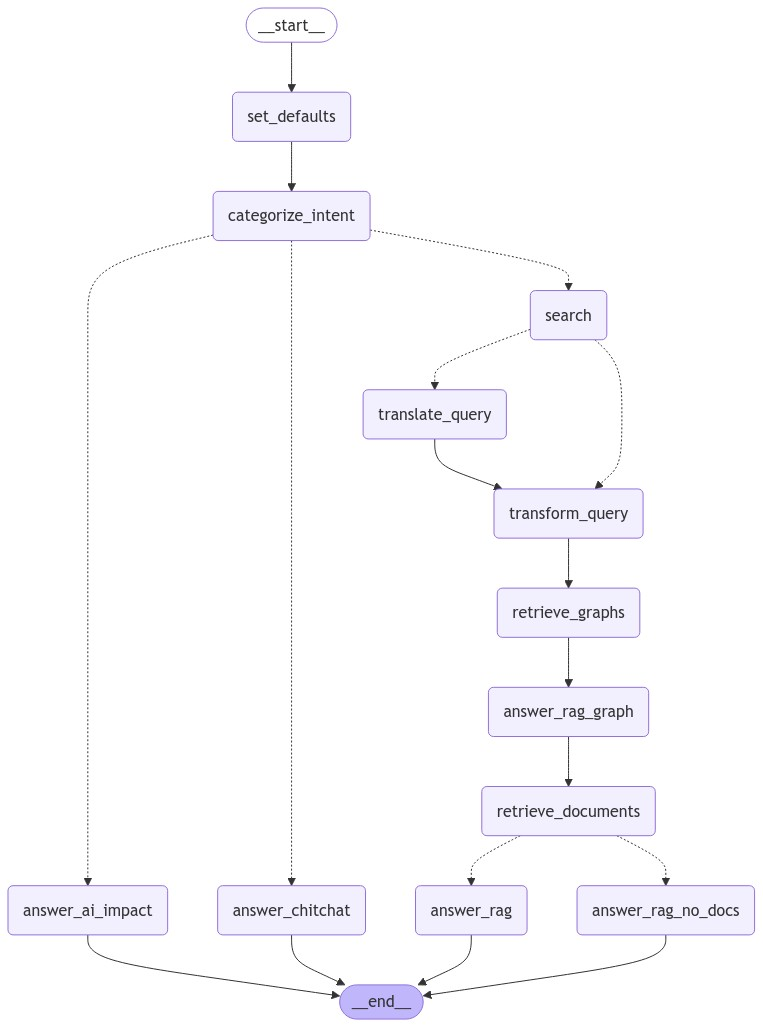

In [29]:
app = make_graph_agent(llm=llm, vectorstore_ipcc=vectorstore, vectorstore_graphs=vectorstore_graphs, reranker=reranker)
display_graph(app)

In [30]:
from climateqa.engine.chains.chitchat_categorization import make_chitchat_intent_categorization_chain

chain = make_chitchat_intent_categorization_chain(llm)
chain.invoke({"input": "should i eat fish"})

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'environment': True}

### 5.2 Testing graph agent

---- Translate query ----


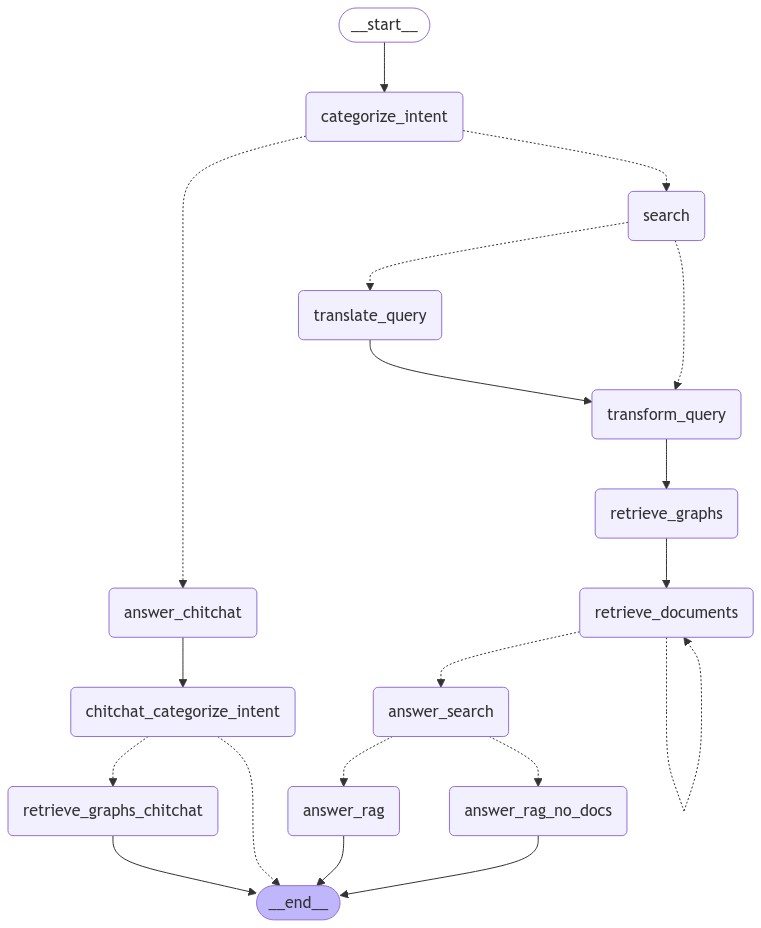

In [36]:
from climateqa.engine.graph import make_graph_agent, display_graph

app = make_graph_agent(llm=llm, vectorstore_ipcc=vectorstore, vectorstore_graphs=vectorstore_graphs, reranker=reranker)
display_graph(app)

In [32]:
from climateqa.engine.chains.prompts import audience_prompts
from front.utils import make_html_source,parse_output_llm_with_sources,serialize_docs,make_toolbox,generate_html_graphs
from gradio import ChatMessage
init_prompt = ""

docs = []
docs_used = True
docs_html = ""
current_graphs = []
output_query = ""
output_language = ""
output_keywords = ""
gallery = []
updates = []
start_streaming = False

steps_display = {
    "categorize_intent":("🔄️ Analyzing user message",True),
    "transform_query":("🔄️ Thinking step by step to answer the question",True),
    "retrieve_documents":("🔄️ Searching in the knowledge base",False),
}
query = "what is the impact of radiative forcing"
inputs = {"user_input": query,"audience": audience_prompts["general"] ,"sources": ["IPCC", "IPBES", "IPOS"]}
history = [ChatMessage(role="assistant", content=init_prompt)]
history + [ChatMessage(role="user", content=query)]


result = app.astream_events(inputs,version = "v1") #{"callbacks":[MyCustomAsyncHandler()]})

async for event in result:
    if "langgraph_node" in event["metadata"]:
        node = event["metadata"]["langgraph_node"]

        if event["event"] == "on_chain_end" and event["name"] == "retrieve_documents" :# when documents are retrieved
            try:
                docs = event["data"]["output"]["documents"]
                docs_html = []
                for i, d in enumerate(docs, 1):
                    docs_html.append(make_html_source(d, i))
                
                used_documents = used_documents + [d.metadata["name"] for d in docs]
                history[-1].content = "Adding sources :\n\n - " + "\n - ".join(np.unique(used_documents))
                    
                docs_html = "".join(docs_html)
                
            except Exception as e:
                print(f"Error getting documents: {e}")
                print(event)

        elif event["name"] in steps_display.keys() and event["event"] == "on_chain_start": #display steps
            event_description,display_output = steps_display[node]
            if not hasattr(history[-1], 'metadata') or history[-1].metadata["title"] != event_description: # if a new step begins
                history.append(ChatMessage(role="assistant", content = "", metadata={'title' :event_description}))

        elif event["name"] != "transform_query" and event["event"] == "on_chat_model_stream" and node in ["answer_rag", "answer_search"]:# if streaming answer
            if start_streaming == False:
                start_streaming = True
                history.append(ChatMessage(role="assistant", content = ""))
            answer_message_content +=  event["data"]["chunk"].content
            answer_message_content = parse_output_llm_with_sources(answer_message_content)
            history[-1] = ChatMessage(role="assistant", content = answer_message_content)
    
        elif event["name"] in ["retrieve_graphs", "retrieve_graphs_ai"] and event["event"] == "on_chain_end":
            try:
                recommended_content = event["data"]["output"]["recommended_content"]
                # graphs = [
                #     {
                #         "embedding": x.metadata["returned_content"],
                #         "metadata": {
                #             "source": x.metadata["source"],
                #             "category": x.metadata["category"]
                #             }
                #             } for x in recommended_content if x.metadata["source"] == "OWID"
                #             ]
                
                unique_graphs = []
                seen_embeddings = set()

                for x in recommended_content:
                    embedding = x.metadata["returned_content"]
                    
                    # Check if the embedding has already been seen
                    if embedding not in seen_embeddings:
                        unique_graphs.append({
                            "embedding": embedding,
                            "metadata": {
                                "source": x.metadata["source"],
                                "category": x.metadata["category"]
                            }
                        })
                        # Add the embedding to the seen set
                        seen_embeddings.add(embedding)


                categories = {}
                for graph in unique_graphs:
                    category = graph['metadata']['category']
                    if category not in categories:
                        categories[category] = []
                    categories[category].append(graph['embedding'])

                # graphs_html = ""
                for category, embeddings in categories.items():
                    # graphs_html += f"<h3>{category}</h3>"
                    # current_graphs.append(f"<h3>{category}</h3>")
                    for embedding in embeddings:
                        current_graphs.append([embedding, category])
                        # graphs_html += f"<div>{embedding}</div>"
                                            
            except Exception as e:
                print(f"Error getting graphs: {e}")

INFO:httpx:HTTP Request: GET https://api.gradio.app/gradio-messaging/en "HTTP/1.1 200 OK"
/tmp/ipykernel_13585/659967580.py:28: LangChainBetaWarning: This API is in beta and may change in the future.
  result = app.astream_events(inputs,version = "v1") #{"callbacks":[MyCustomAsyncHandler()]})


TypeError: 'Metadata' object is not subscriptable

---- Categorize_message ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Output intent categorization: {'intent': 'search'}

---- Transform query ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
/home/tim/ai4s/climate_qa/climate-question-answering/climateqa/engine/chains/graph_retriever.py:91: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  docs_question = retriever.get_relevant_documents(question)


---- Retrieving graphs ----
Subquestion 0: What is radiative forcing and how does it affect climate change?
8 graphs retrieved for subquestion 1: [Document(metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_386', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/contributions-global-temp-change?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': "This is shown as a country or region's share of the global mean surface temperature change as a result of its cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxide.", 'url': 'https://ourworldindata.org/grapher/contributions-global-temp-change', 'similarity_score': 0.8423357605934143, 'content': 'Global warming: Contributions to the change in global mean surface temperature', 'reranking_score': 0.005384462885558605, 'query_used_for_retrieval': 'What is radiative forcing and how

---- Retrieve documents ----


---- Answer RAG ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Answer:
Radiative forcing is a key concept in understanding how human activities affect the Earth's climate. It refers to the change in energy balance in the Earth's atmosphere due to various factors, primarily greenhouse gases (GHGs) and aerosols. Here’s a breakdown of its impact:

### What is Radiative Forcing?
- **Definition**: Radiative forcing measures how much energy is added to or taken away from the Earth's atmosphere. Positive radiative forcing leads to warming, while negative radiative forcing can cause cooling.
- **Current Status**: As of 2019, human-caused radiative forcing was estimated at 2.72 watts per square meter (W/m²) compared to pre-industrial levels (1750). This represents a significant increase, primarily due to higher concentrations of greenhouse gases like carbon dioxide (CO2) [Doc 1, Doc 9].

### How Does It Affect the Climate?
- **Energy Accumulation**: The increase in radiative forcing results in more energy being trapped in the climate system, leading to a

In [33]:
from climateqa.engine.chains.prompts import audience_prompts
from front.utils import make_html_source,parse_output_llm_with_sources,serialize_docs,make_toolbox,generate_html_graphs
from gradio import ChatMessage
init_prompt = ""

docs = []
docs_used = True
docs_html = ""
current_graphs = []
output_query = ""
output_language = ""
output_keywords = ""
gallery = []
updates = []
start_streaming = False
history = [ChatMessage(role="assistant", content=init_prompt)]
steps_display = {
    "categorize_intent":("🔄️ Analyzing user message",True),
    "transform_query":("🔄️ Thinking step by step to answer the question",True),
    "retrieve_documents":("🔄️ Searching in the knowledge base",False),
}
query = "what is the impact of radiative forcing"
inputs = {"user_input": query,"audience": audience_prompts["general"] ,"sources": ["IPCC", "IPBES", "IPOS"]}

result = app.astream_events(inputs,version = "v1") #{"callbacks":[MyCustomAsyncHandler()]})

async for event in result:
    if "langgraph_node" in event["metadata"]:
        node = event["metadata"]["langgraph_node"]

        if event["event"] == "on_chain_end" and event["name"] == "retrieve_documents" :# when documents are retrieved
            try:
                docs = event["data"]["output"]["documents"]
                docs_html = []
                for i, d in enumerate(docs, 1):
                    docs_html.append(make_html_source(d, i))
                
                used_documents = used_documents + [d.metadata["name"] for d in docs]
                history[-1].content = "Adding sources :\n\n - " + "\n - ".join(np.unique(used_documents))
                    
                docs_html = "".join(docs_html)
                
            except Exception as e:
                print(f"Error getting documents: {e}")
                print(event)

        elif event["name"] in steps_display.keys() and event["event"] == "on_chain_start": #display steps
            event_description,display_output = steps_display[node]
            if not hasattr(history[-1], 'metadata') or history[-1].metadata["title"] != event_description: # if a new step begins
                history.append(ChatMessage(role="assistant", content = "", metadata={'title' :event_description}))

        elif event["name"] != "transform_query" and event["event"] == "on_chat_model_stream" and node in ["answer_rag", "answer_search"]:# if streaming answer
            if start_streaming == False:
                start_streaming = True
                history.append(ChatMessage(role="assistant", content = ""))
            answer_message_content +=  event["data"]["chunk"].content
            answer_message_content = parse_output_llm_with_sources(answer_message_content)
            history[-1] = ChatMessage(role="assistant", content = answer_message_content)
    
        elif event["name"] in ["retrieve_graphs", "retrieve_graphs_ai"] and event["event"] == "on_chain_end":
            try:
                recommended_content = event["data"]["output"]["recommended_content"]
                # graphs = [
                #     {
                #         "embedding": x.metadata["returned_content"],
                #         "metadata": {
                #             "source": x.metadata["source"],
                #             "category": x.metadata["category"]
                #             }
                #             } for x in recommended_content if x.metadata["source"] == "OWID"
                #             ]
                
                unique_graphs = []
                seen_embeddings = set()

                for x in recommended_content:
                    embedding = x.metadata["returned_content"]
                    
                    # Check if the embedding has already been seen
                    if embedding not in seen_embeddings:
                        unique_graphs.append({
                            "embedding": embedding,
                            "metadata": {
                                "source": x.metadata["source"],
                                "category": x.metadata["category"]
                            }
                        })
                        # Add the embedding to the seen set
                        seen_embeddings.add(embedding)


                categories = {}
                for graph in unique_graphs:
                    category = graph['metadata']['category']
                    if category not in categories:
                        categories[category] = []
                    categories[category].append(graph['embedding'])

                # graphs_html = ""
                for category, embeddings in categories.items():
                    # graphs_html += f"<h3>{category}</h3>"
                    # current_graphs.append(f"<h3>{category}</h3>")
                    for embedding in embeddings:
                        current_graphs.append([embedding, category])
                        # graphs_html += f"<div>{embedding}</div>"
                                            
            except Exception as e:
                print(f"Error getting graphs: {e}")

    
    
    
    
    
    # ### old
    # if event["event"] == "on_chat_model_stream" and event["metadata"]["langgraph_node"] in ["answer_rag", "answer_rag_no_docs", "answer_chitchat", "answer_ai_impact"]:
    #     if start_streaming == False:
    #         start_streaming = True
    #         history.append(ChatMessage(role="assistant", content = ""))

    #     answer_message_content +=  event["data"]["chunk"].content
    #     answer_message_content = parse_output_llm_with_sources(answer_message_content)
    #     history[-1] = ChatMessage(role="assistant", content = answer_message_content)


    #     if docs_used is True and event["metadata"]["langgraph_node"] in ["answer_rag_no_docs", "answer_chitchat", "answer_ai_impact"]:
    #         docs_used = False
    
    # elif docs_used is True and event["name"] == "retrieve_documents" and event["event"] == "on_chain_end":
    #     try:
    #         docs = event["data"]["output"]["documents"]
    #         docs_html = []
    #         for i, d in enumerate(docs, 1):
    #             docs_html.append(make_html_source(d, i))
    #         docs_html = "".join(docs_html)

    #     except Exception as e:
    #         print(f"Error getting documents: {e}")
    #         print(event)

    # elif event["name"] == "retrieve_documents" and event["event"] == "on_chain_start":
    #     print(event)
    #     questions = event["data"]["input"]["questions"]
    #     questions = "\n".join([f"{i+1}. {q['question']} ({q['source']})" for i,q in enumerate(questions)])
    #     answer_yet = "🔄️ Searching in the knowledge base\n{questions}"
    #     history[-1] = (query,answer_yet)

    # elif event["name"] in ["retrieve_graphs", "retrieve_graphs_ai"] and event["event"] == "on_chain_end":
    #     try:
    #         recommended_content = event["data"]["output"]["recommended_content"]
    #         # graphs = [
    #         #     {
    #         #         "embedding": x.metadata["returned_content"],
    #         #         "metadata": {
    #         #             "source": x.metadata["source"],
    #         #             "category": x.metadata["category"]
    #         #             }
    #         #             } for x in recommended_content if x.metadata["source"] == "OWID"
    #         #             ]
            
    #         unique_graphs = []
    #         seen_embeddings = set()

    #         for x in recommended_content:
    #             embedding = x.metadata["returned_content"]
                
    #             # Check if the embedding has already been seen
    #             if embedding not in seen_embeddings:
    #                 unique_graphs.append({
    #                     "embedding": embedding,
    #                     "metadata": {
    #                         "source": x.metadata["source"],
    #                         "category": x.metadata["category"]
    #                     }
    #                 })
    #                 # Add the embedding to the seen set
    #                 seen_embeddings.add(embedding)


    #         categories = {}
    #         for graph in unique_graphs:
    #             category = graph['metadata']['category']
    #             if category not in categories:
    #                 categories[category] = []
    #             categories[category].append(graph['embedding'])

    #         # graphs_html = ""
    #         for category, embeddings in categories.items():
    #             # graphs_html += f"<h3>{category}</h3>"
    #             # current_graphs.append(f"<h3>{category}</h3>")
    #             for embedding in embeddings:
    #                 current_graphs.append([embedding, category])
    #                 # graphs_html += f"<div>{embedding}</div>"
                                        
    #     except Exception as e:
    #         print(f"Error getting graphs: {e}")

    # elif event["name"] in steps_display.keys() and event["event"] == "on_chain_start": #display steps
    #     node = event["metadata"]["langgraph_node"]
    #     event_description,display_output = steps_display[node]
    #     if not hasattr(history[-1], 'metadata') or history[-1].metadata["title"] != event_description: # if a new step begins
    #         history.append(ChatMessage(role="assistant", content = "", metadata={'title' :event_description}))

    # for event_name,(event_description,display_output) in steps_display.items():
    #     if event["name"] == event_name:
    #         if event["event"] == "on_chain_start":
    #             # answer_yet = f"<p><span class='loader'></span>{event_description}</p>"
    #             # answer_yet = make_toolbox(event_description, "", checked = False)
    #             answer_yet = event_description

    #             history[-1] = (query,answer_yet)
            # elif event["event"] == "on_chain_end":
            #     answer_yet = ""
            #     history[-1] = (query,answer_yet)
                # if display_output:
                #     print(event["data"]["output"])

    # if op['path'] == path_reformulation: # reforulated question
    #     try:
    #         output_language = op['value']["language"] # str
    #         output_query = op["value"]["question"]
    #     except Exception as e:
    #         raise gr.Error(f"ClimateQ&A Error: {e} - The error has been noted, try another question and if the error remains, you can contact us :)")
    
    # if op["path"] == path_keywords:
    #     try:
    #         output_keywords = op['value']["keywords"] # str
    #         output_keywords = " AND ".join(output_keywords)
    #     except Exception as e:
    #         pass



    # history = [tuple(x) for x in history]

TypeError: 'Metadata' object is not subscriptable

---- Categorize_message ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Output intent categorization: {'intent': 'search'}

---- Transform query ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---- Retrieving graphs ----
Subquestion 0: What is radiative forcing and how does it affect climate change?
8 graphs retrieved for subquestion 1: [Document(metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_386', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/contributions-global-temp-change?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': "This is shown as a country or region's share of the global mean surface temperature change as a result of its cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxide.", 'url': 'https://ourworldindata.org/grapher/contributions-global-temp-change', 'similarity_score': 0.8423357605934143, 'content': 'Global warming: Contributions to the change in global mean surface temperature', 'reranking_score': 0.005384462885558605, 'query_used_for_retrieval': 'What is radiative forcing and how



Answer:
Radiative forcing is a key concept in understanding how human activities affect the Earth's climate. It refers to the change in energy balance in the atmosphere due to various factors, primarily greenhouse gases (GHGs) and aerosols. Here’s a breakdown of its impact:

### Key Points on Radiative Forcing:

- **Human Influence**: Since the mid-18th century, human activities have significantly increased the concentration of greenhouse gases in the atmosphere, leading to a radiative forcing of approximately 2.72 watts per square meter (W/m²) by 2019. This represents a 19% increase since the last major assessment in 2014, primarily due to rising GHG levels [Doc 1, Doc 3].

- **Energy Accumulation**: The increase in radiative forcing results in more energy being trapped in the climate system, which leads to warming. The average rate of heating has risen from 0.50 W/m² between 1971 and 2006 to 0.79 W/m² from 2006 to 2018. Most of this heat (91%) is absorbed by the oceans, while land,

In [44]:
# output = await app.ainvoke({"user_input": "should I be a vegetarian ?"})
output = await app.ainvoke({"user_input": "what is the impact of climate change ?", "audience": "scientifique", "sources": ["IPCC", "IPBES", "IPOS"]})
output

---- Categorize_message ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Output intent categorization: {'intent': 'search'}

---- Transform query ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---- Retrieving graphs ----
Subquestion 0: What are the effects of climate change on the environment?
8 graphs retrieved for subquestion 1: [Document(metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_349', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/co2-emissions-and-gdp?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Consumption-based emissions are national emissions that have been adjusted for trade. This measures fossil fuel and industry emissions. Land-use change is not included.', 'url': 'https://ourworldindata.org/grapher/co2-emissions-and-gdp', 'similarity_score': 0.7941333055496216, 'content': 'Change in CO2 emissions and GDP', 'reranking_score': 0.279598593711853, 'query_used_for_retrieval': 'What are the effects of climate change on the environment?', 'sources_used': ['IEA', 'OWID']}, page_content='Change in CO2 emissions a

---- Retrieve documents ----


---- Answer RAG ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Answer:
Climate change has profound and multifaceted impacts on both human systems and the natural environment, with significant implications for health, biodiversity, agriculture, and infrastructure. Here are the key impacts:

### 1. **Human Health**
- **Physical and Mental Health**: Climate change adversely affects physical health globally, leading to increased mortality and morbidity due to extreme heat events. It also exacerbates mental health issues, particularly in vulnerable populations [Doc 1, Doc 11].
- **Disease Dynamics**: There is a notable increase in climate-related diseases, including vector-borne diseases (e.g., malaria, dengue) due to the expansion of disease vectors. Additionally, the incidence of water- and food-borne diseases has risen, influenced by higher temperatures and increased rainfall, which can lead to outbreaks of diseases like cholera [Doc 1, Doc 13].
- **Food Security and Nutrition**: Climate change impacts food production through altered agricultural 

{'user_input': 'what is the impact of climate change ?',
 'language': 'English',
 'intent': 'search',
 'query': 'what is the impact of climate change ?',
 'remaining_questions': [],
 'n_questions': 2,
 'answer': 'Climate change has profound and multifaceted impacts on both human systems and the natural environment, with significant implications for health, biodiversity, agriculture, and infrastructure. Here are the key impacts:\n\n### 1. **Human Health**\n- **Physical and Mental Health**: Climate change adversely affects physical health globally, leading to increased mortality and morbidity due to extreme heat events. It also exacerbates mental health issues, particularly in vulnerable populations [Doc 1, Doc 11].\n- **Disease Dynamics**: There is a notable increase in climate-related diseases, including vector-borne diseases (e.g., malaria, dengue) due to the expansion of disease vectors. Additionally, the incidence of water- and food-borne diseases has risen, influenced by higher tem

In [47]:
output.keys()

dict_keys(['user_input', 'language', 'intent', 'query', 'remaining_questions', 'n_questions', 'answer', 'audience', 'documents', 'recommended_content'])

In [36]:
output["recommended_content"]

[Document(metadata={'category': 'Meat & Dairy Production', 'doc_id': 'owid_1678', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/environmental-footprint-milks?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Impacts are measured per liter of milk. These are based on a meta-analysis of food system impact studies across the supply chain which includes land use change, on-farm production, processing, transport, and packaging.', 'url': 'https://ourworldindata.org/grapher/environmental-footprint-milks', 'similarity_score': 0.6826351881027222, 'content': 'Environmental footprints of dairy and plant-based milks', 'reranking_score': 0.025419369339942932, 'query_used_for_retrieval': 'What are the environmental impacts of being a vegetarian?', 'sources_used': ['IEA', 'OWID']}, page_content='Environmental footprints of dairy and plant-based milks'),
 Document(metadata={

In [38]:
# display(Markdown(_combine_recommended_content(output["recommended_content"])))

In [27]:
from climateqa.engine.chains.answer_rag_graph import make_rag_graph_chain, _format_graphs

chain = make_rag_graph_chain(llm)
chain.invoke({"query": "salade de fruits", "recommended_content": output["recommended_content"]})

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'graphs': [{'embedding': '<iframe src="https://ourworldindata.org/grapher/fruit-consumption-by-fruit-type?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>',
   'category': 'Diet Compositions',
   'source': 'OWID'},
  {'embedding': '<iframe src="https://ourworldindata.org/grapher/fruit-consumption-per-capita?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>',
   'category': 'Diet Compositions',
   'source': 'OWID'},
  {'embedding': '<iframe src="https://ourworldindata.org/grapher/average-per-capita-fruit-intake-vs-minimum-recommended-guidelines?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>',
   'category': 'Diet Compositions',
   'source': 'OWID'}]}

: 

In [19]:
graphs = []
for x in output["recommended_content"]:
    embedding = x.metadata["returned_content"]
    
    # Check if the embedding has already been seen
    graphs.append({
        "title": x.page_content,
        "embedding": embedding,
        "metadata": {
            "source": x.metadata["source"],
            "category": x.metadata["category"]
        }
    })
format_data(graphs)

'Title: Nationally determined contributions to climate change\nEmbedding: <iframe src="https://ourworldindata.org/grapher/nationally-determined-contributions?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>\nSource: OWID\nCategory: Climate Change\n\nTitle: Contribution to global mean surface temperature rise from fossil sources\nEmbedding: <iframe src="https://ourworldindata.org/grapher/global-warming-fossil?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>\nSource: OWID\nCategory: CO2 & Greenhouse Gas Emissions\n\nTitle: Global warming contributions by gas and source\nEmbedding: <iframe src="https://ourworldindata.org/grapher/global-warming-by-gas-and-source?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>\nSource: OWID\nCategory: CO2 & Greenhouse Gas Emissions\n\nTit

In [17]:
docs_used = True

async for event in app.astream_events({"user_input": "salade de fruits"}, version = "v1"):
    if docs_used is True and "metadata" in event and "langgraph_node" in event["metadata"]:
        if event["metadata"]["langgraph_node"] in ["answer_rag_no_docs", "answer_chitchat", "answer_ai_impact"]:
            docs_used = False
            print(f"\nDOCS USED: {docs_used}\n")
    # if event["name"] == "retrieve_documents" and event["event"] == "on_chain_end":
        # print(event)
    # print(event)

---- Setting defaults ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---- Retrieving graphs ----
Subquestion 0: What are the ingredients of a fruit salad?
8 graphs retrieved for subquestion 1: [Document(page_content='Fruit consumption by type', metadata={'category': 'Diet Compositions', 'doc_id': 'owid_854', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/fruit-consumption-by-fruit-type?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Average fruit consumption per person, differentiated by fruit types, measured in kilograms per year.', 'url': 'https://ourworldindata.org/grapher/fruit-consumption-by-fruit-type', 'similarity_score': 0.8464472889900208, 'content': 'Fruit consumption by type', 'reranking_score': 3.988455864600837e-05, 'query_used_for_retrieval': 'What are the ingredients of a fruit salad?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Dietary compositions by commodity group', metadata={'category': 'Die

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



DOCS USED: False



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Answer:
Ce n'est pas lié aux questions environnementales, ce n'est pas de mon ressort.


In [13]:
inputs = {'user_input': 'impact of ai?', 'audience': 'expert and climate scientists that are not afraid of technical terms', 'sources': ['IPCC']}
result = app.astream_events(inputs,version = "v1")

/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


In [35]:
async for event in result:
    print(event)

{'event': 'on_chain_start', 'run_id': 'da753bb9-2339-4fc0-b1d7-86443019c4df', 'name': 'LangGraph', 'tags': [], 'metadata': {}, 'data': {'input': {'user_input': 'impact of ai?', 'audience': 'expert and climate scientists that are not afraid of technical terms', 'sources': ['IPCC']}}}
{'event': 'on_chain_start', 'name': '__start__', 'run_id': '07d726da-2d7c-48a3-ad2b-5c28e29729a9', 'tags': ['graph:step:0', 'langsmith:hidden'], 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__'}, 'data': {'input': {'user_input': 'impact of ai?', 'audience': 'expert and climate scientists that are not afraid of technical terms', 'sources': ['IPCC']}}}
{'event': 'on_chain_end', 'name': '__start__', 'run_id': '07d726da-2d7c-48a3-ad2b-5c28e29729a9', 'tags': ['graph:step:0', 'langsmith:hidden'], 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__'}, 'data': {'input': {'user_input': 'impact of ai?', 'audience': 'expert and climate scientists that are not afraid of technical terms', 'sour

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '2d9ccf59-3d78-42b1-8458-83a9c3479ef8', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 2, 'langgraph_node': 'categorize_intent', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'IntentCategorizer'}}, id='run-2d9ccf59-3d78-42b1-8458-83a9c3479ef8')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '2d9ccf59-3d78-42b1-8458-83a9c3479ef8', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 2, 'langgraph_node': 'categorize_intent', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-2d9ccf59-3d78-42b1-8458-83a9c3479ef8')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '2d9ccf59-3d78-42b1-8458-83a9c3479ef8', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 2, 'langgraph_node': 'categorize_inten

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'db848c5f-43af-45e1-8b97-345044f399d6', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 3, 'langgraph_node': 'answer_ai_impact', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', id='run-db848c5f-43af-45e1-8b97-345044f399d6')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'db848c5f-43af-45e1-8b97-345044f399d6', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 3, 'langgraph_node': 'answer_ai_impact', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='The', id='run-db848c5f-43af-45e1-8b97-345044f399d6')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'db848c5f-43af-45e1-8b97-345044f399d6', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 3, 'langgraph_node': 'answer_ai_impact', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content=' environmental', id='run-db848c5f-43af-45e1-8b97-345044f399d6')}}
{'event': 'on_cha

: 

## 6. Gradio

In [31]:
from front.utils import make_html_source,parse_output_llm_with_sources,serialize_docs,make_toolbox
query = inputs["user_input"]
steps_display = {
"categorize_intent":("🔄️ Analyzing user message",True),
"transform_query":("🔄️ Thinking step by step to answer the question",True),
"retrieve_documents":("🔄️ Searching in the knowledge base",False),
}
history = [(query,None)]
start_streaming = False
intent = None


async for event in result:

    if event["event"] == "on_chat_model_stream" and event["metadata"]["langgraph_node"] in ["answer_rag", "answer_chitchat", "answer_ai_impact"]:
        if start_streaming == False:
            start_streaming = True
            history[-1] = (query,"")

        new_token = event["data"]["chunk"].content
        # time.sleep(0.01)
        previous_answer = history[-1][1]
        previous_answer = previous_answer if previous_answer is not None else ""
        answer_yet = previous_answer + new_token
        answer_yet = parse_output_llm_with_sources(answer_yet)
        history[-1] = (query,answer_yet)

    
    elif event["name"] == "retrieve_documents" and event["event"] == "on_chain_end":
        try:
            docs = event["data"]["output"]["documents"]
            docs_html = []
            for i, d in enumerate(docs, 1):
                docs_html.append(make_html_source(d, i))
            docs_html = "".join(docs_html)
        except Exception as e:
            print(f"Error getting documents: {e}")
            print(event)

    # elif event["name"] == "retrieve_documents" and event["event"] == "on_chain_start":
    #     print(event)
    #     questions = event["data"]["input"]["questions"]
    #     questions = "\n".join([f"{i+1}. {q['question']} ({q['source']})" for i,q in enumerate(questions)])
    #     answer_yet = "🔄️ Searching in the knowledge base\n{questions}"
    #     history[-1] = (query,answer_yet)

    elif event["name"] == "retrieve_graphs" and event["event"] == "on_chain_end":
        try:
            graphs = event["data"]["output"]["recommended_content"]
        except Exception as e:
            print(f"Error getting graphs: {e}")
            print(event)


    for event_name,(event_description,display_output) in steps_display.items():
        if event["name"] == event_name:
            if event["event"] == "on_chain_start":
                # answer_yet = f"<p><span class='loader'></span>{event_description}</p>"
                # answer_yet = make_toolbox(event_description, "", checked = False)
                answer_yet = event_description
                history[-1] = (query,answer_yet)
            # elif event["event"] == "on_chain_end":
            #     answer_yet = ""
            #     history[-1] = (query,answer_yet)
                # if display_output:
                #     print(event["data"]["output"])

    # if op['path'] == path_reformulation: # reforulated question
    #     try:
    #         output_language = op['value']["language"] # str
    #         output_query = op["value"]["question"]
    #     except Exception as e:
    #         raise gr.Error(f"ClimateQ&A Error: {e} - The error has been noted, try another question and if the error remains, you can contact us :)")
    
    # if op["path"] == path_keywords:
    #     try:
    #         output_keywords = op['value']["keywords"] # str
    #         output_keywords = " AND ".join(output_keywords)
    #     except Exception as e:
    #         pass



    history = [tuple(x) for x in history]
    # yield history,docs_html,output_query,output_language,gallery,output_query,output_keywords

In [40]:
from langchain_core.documents import Document

graphs = [Document(page_content='Global warming contributions by gas and source', metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_383', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/global-warming-by-gas-and-source?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'The global mean surface temperature change as a result of the cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxide.', 'url': 'https://ourworldindata.org/grapher/global-warming-by-gas-and-source', 'similarity_score': 0.5550143122673035, 'content': 'Global warming contributions by gas and source', 'reranking_score': 0.651607871055603, 'query_used_for_retrieval': 'How do human activities contribute to global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Global warming contributions by gas and source', metadata={'category': 'Climate Change', 'doc_id': 'owid_764', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/global-warming-by-gas-and-source?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'The global mean surface temperature change as a result of the cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxide.', 'url': 'https://ourworldindata.org/grapher/global-warming-by-gas-and-source', 'similarity_score': 0.5550143122673035, 'content': 'Global warming contributions by gas and source', 'reranking_score': 0.651607871055603, 'query_used_for_retrieval': 'How do human activities contribute to global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Global warming contributions from fossil fuels and land use', metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_384', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/warming-fossil-fuels-land-use?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': "The global mean surface temperature change as a result of a country or region's cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxide.", 'url': 'https://ourworldindata.org/grapher/warming-fossil-fuels-land-use', 'similarity_score': 0.6049439907073975, 'content': 'Global warming contributions from fossil fuels and land use', 'reranking_score': 0.22002366185188293, 'query_used_for_retrieval': 'How do human activities contribute to global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Global warming contributions from fossil fuels and land use', metadata={'category': 'Climate Change', 'doc_id': 'owid_765', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/warming-fossil-fuels-land-use?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': "The global mean surface temperature change as a result of a country or region's cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxide.", 'url': 'https://ourworldindata.org/grapher/warming-fossil-fuels-land-use', 'similarity_score': 0.6049439907073975, 'content': 'Global warming contributions from fossil fuels and land use', 'reranking_score': 0.22002366185188293, 'query_used_for_retrieval': 'How do human activities contribute to global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Main sources of methane emissions', metadata={'appears_in': 'Global Methane Tracker 2024', 'appears_in_url': 'https://www.iea.org/reports/global-methane-tracker-2024', 'doc_id': 'iea_133', 'returned_content': 'https://www.iea.org/data-and-statistics/charts/main-sources-of-methane-emissions', 'source': 'IEA', 'sources': 'Methane emissions and abatement potential for oil, gas, and coal are based on the IEA (2023) Global Methane Tracker (https://www.iea.org/data-and-statistics/data-tools/methane-tracker-data-explorer) ; agriculture and waste is based on UNEP (2023), Global Methane Assessment (https://www.unep.org/resources/report/global-methane-assessment-benefits-and-costs-mitigating-methane-emissions). Emissions from biomass and bioenergy burning, which total around 10 Mt (https://essd.copernicus.org/articles/12/1561/2020/) of methane per year each, are not shown.', 'similarity_score': 0.6158384084701538, 'content': 'Main sources of methane emissions', 'reranking_score': 0.0806397795677185, 'query_used_for_retrieval': 'What are the main causes of global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Global warming: Contributions to the change in global mean surface temperature', metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_386', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/contributions-global-temp-change?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': "This is shown as a country or region's share of the global mean surface temperature change as a result of its cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxide.", 'url': 'https://ourworldindata.org/grapher/contributions-global-temp-change', 'similarity_score': 0.6807445883750916, 'content': 'Global warming: Contributions to the change in global mean surface temperature', 'reranking_score': 0.03409431874752045, 'query_used_for_retrieval': 'How do human activities contribute to global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Global warming: Contributions to the change in global mean surface temperature', metadata={'category': 'Climate Change', 'doc_id': 'owid_766', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/contributions-global-temp-change?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': "This is shown as a country or region's share of the global mean surface temperature change as a result of its cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxide.", 'url': 'https://ourworldindata.org/grapher/contributions-global-temp-change', 'similarity_score': 0.6807445883750916, 'content': 'Global warming: Contributions to the change in global mean surface temperature', 'reranking_score': 0.03409431874752045, 'query_used_for_retrieval': 'How do human activities contribute to global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Carbon dioxide emissions factors', metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_342', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/carbon-dioxide-emissions-factor?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Emissions factors quantify the average CO₂ output per unit of energy. They are measured in kilograms of CO₂ per megawatt-hour (MWh) of energy from various fossil fuel sources.', 'url': 'https://ourworldindata.org/grapher/carbon-dioxide-emissions-factor', 'similarity_score': 0.6963810324668884, 'content': 'Carbon dioxide emissions factors', 'reranking_score': 0.007733839564025402, 'query_used_for_retrieval': 'What are the main causes of global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Carbon dioxide emissions factors', metadata={'category': 'Fossil Fuels', 'doc_id': 'owid_1408', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/carbon-dioxide-emissions-factor?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Emissions factors quantify the average CO₂ output per unit of energy. They are measured in kilograms of CO₂ per megawatt-hour (MWh) of energy from various fossil fuel sources.', 'url': 'https://ourworldindata.org/grapher/carbon-dioxide-emissions-factor', 'similarity_score': 0.6963810324668884, 'content': 'Carbon dioxide emissions factors', 'reranking_score': 0.007733839564025402, 'query_used_for_retrieval': 'What are the main causes of global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Contribution to global mean surface temperature rise from agriculture and land use', metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_359', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/global-warming-land?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': "The global mean surface temperature change as a result of a country or region's cumulative emissions of carbon dioxide, methane, and nitrous oxide. This is for land use and agriculture only.", 'url': 'https://ourworldindata.org/grapher/global-warming-land', 'similarity_score': 0.7010847330093384, 'content': 'Contribution to global mean surface temperature rise from agriculture and land use', 'reranking_score': 0.006090907845646143, 'query_used_for_retrieval': 'How do human activities contribute to global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Greenhouse gas emissions', metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_387', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/total-ghg-emissions?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Greenhouse gas emissions include carbon dioxide, methane and nitrous oxide from all sources, including land-use change. They are measured in tonnes of carbon dioxide-equivalents over a 100-year timescale.', 'url': 'https://ourworldindata.org/grapher/total-ghg-emissions', 'similarity_score': 0.711588978767395, 'content': 'Greenhouse gas emissions', 'reranking_score': 0.001999091589823365, 'query_used_for_retrieval': 'What are the main causes of global warming?', 'sources_used': ['IEA', 'OWID']})]
graphs

[Document(metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_383', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/global-warming-by-gas-and-source?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'The global mean surface temperature change as a result of the cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxide.', 'url': 'https://ourworldindata.org/grapher/global-warming-by-gas-and-source', 'similarity_score': 0.5550143122673035, 'content': 'Global warming contributions by gas and source', 'reranking_score': 0.651607871055603, 'query_used_for_retrieval': 'How do human activities contribute to global warming?', 'sources_used': ['IEA', 'OWID']}, page_content='Global warming contributions by gas and source'),
 Document(metadata={'category': 'Climate Change', 'doc_id': 'owid_764', 'returned_content': '<iframe src="ht

In [41]:
graphs = [
            {
                "embedding": x.metadata["returned_content"],
                "metadata": {
                    "source": x.metadata["source"],
                    "category": x.metadata["category"]
                    }
                } for x in graphs if x.metadata["source"] == "OWID"
            ]

graphs

[{'embedding': '<iframe src="https://ourworldindata.org/grapher/global-warming-by-gas-and-source?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>',
  'metadata': {'source': 'OWID',
   'category': 'CO2 & Greenhouse Gas Emissions'}},
 {'embedding': '<iframe src="https://ourworldindata.org/grapher/global-warming-by-gas-and-source?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>',
  'metadata': {'source': 'OWID', 'category': 'Climate Change'}},
 {'embedding': '<iframe src="https://ourworldindata.org/grapher/warming-fossil-fuels-land-use?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>',
  'metadata': {'source': 'OWID',
   'category': 'CO2 & Greenhouse Gas Emissions'}},
 {'embedding': '<iframe src="https://ourworldindata.org/grapher/warming-fossil-fuels-land-use?tab=map" l

In [42]:
from collections import defaultdict

def generate_html(graphs):
    # Organize graphs by category
    categories = defaultdict(list)
    for graph in graphs:
        category = graph['metadata']['category']
        categories[category].append(graph['embedding'])

    # Begin constructing the HTML
    html_code = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Graphs by Category</title>
    <style>
        .tab-content {
            display: none;
        }
        .tab-content.active {
            display: block;
        }
        .tabs {
            margin-bottom: 20px;
        }
        .tab-button {
            background-color: #ddd;
            border: none;
            padding: 10px 20px;
            cursor: pointer;
            margin-right: 5px;
        }
        .tab-button.active {
            background-color: #ccc;
        }
    </style>
    <script>
        function showTab(tabId) {
            var contents = document.getElementsByClassName('tab-content');
            var buttons = document.getElementsByClassName('tab-button');
            for (var i = 0; i < contents.length; i++) {
                contents[i].classList.remove('active');
                buttons[i].classList.remove('active');
            }
            document.getElementById(tabId).classList.add('active');
            document.querySelector('button[data-tab="'+tabId+'"]').classList.add('active');
        }
    </script>
</head>
<body>
    <div class="tabs">
'''

    # Add buttons for each category
    for i, category in enumerate(categories.keys()):
        active_class = 'active' if i == 0 else ''
        html_code += f'<button class="tab-button {active_class}" onclick="showTab(\'tab-{i}\')" data-tab="tab-{i}">{category}</button>'

    html_code += '</div>'

    # Add content for each category
    for i, (category, embeds) in enumerate(categories.items()):
        active_class = 'active' if i == 0 else ''
        html_code += f'<div id="tab-{i}" class="tab-content {active_class}">'
        for embed in embeds:
            html_code += embed
        html_code += '</div>'

    html_code += '''
</body>
</html>
'''

    return html_code


In [43]:
generate_html(graphs)

'\n<!DOCTYPE html>\n<html lang="en">\n<head>\n    <meta charset="UTF-8">\n    <meta name="viewport" content="width=device-width, initial-scale=1.0">\n    <title>Graphs by Category</title>\n    <style>\n        .tab-content {\n            display: none;\n        }\n        .tab-content.active {\n            display: block;\n        }\n        .tabs {\n            margin-bottom: 20px;\n        }\n        .tab-button {\n            background-color: #ddd;\n            border: none;\n            padding: 10px 20px;\n            cursor: pointer;\n            margin-right: 5px;\n        }\n        .tab-button.active {\n            background-color: #ccc;\n        }\n    </style>\n    <script>\n        function showTab(tabId) {\n            var contents = document.getElementsByClassName(\'tab-content\');\n            var buttons = document.getElementsByClassName(\'tab-button\');\n            for (var i = 0; i < contents.length; i++) {\n                contents[i].classList.remove(\'active\');

In [65]:
vectorstore_graphs.similarity_search_with_relevance_scores("What is the trend of clean water?")[0][0]

Document(metadata={'category': 'Water Use & Stress', 'doc_id': 'owid_2184', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/water-bodies-good-water-quality?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Water quality is assessed by means of core physical and chemical parameters that reflect natural water quality. A water body is classified as "good" quality if at least 80% of monitoring values meet target quality levels.', 'url': 'https://ourworldindata.org/grapher/water-bodies-good-water-quality'}, page_content='Share of water bodies with good ambient water quality')

In [66]:
test_graphs = [x[0].metadata["returned_content"] for x in vectorstore_graphs.similarity_search_with_relevance_scores("What is the trend of clean water?")]
test_graphs

['<iframe src="https://ourworldindata.org/grapher/water-bodies-good-water-quality?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>',
 '<iframe src="https://ourworldindata.org/grapher/water-bodies-good-water-quality?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>',
 '<iframe src="https://ourworldindata.org/grapher/water-bodies-good-water-quality?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>',
 '<iframe src="https://ourworldindata.org/grapher/population-using-at-least-basic-drinking-water?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>']

In [67]:
# simple gradio
import gradio as gr
with gr.Blocks() as blocks:
    state_test = gr.State([])
    
    button = gr.Button("abc")
    button.click(lambda : graphs, inputs = [], outputs = state_test)
    with gr.Column():
        # gr.HTML(generate_html(graphs), elem_id="graphs-placeholder")
        gr.HTML(test_graphs)
        # gr.HTML(generate_html(state_test), elem_id="graphs-placeholder")

blocks.launch()

    

INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://127.0.0.1:7868/gradio_api/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7868/ "HTTP/1.1 200 OK"


* Running on local URL:  http://127.0.0.1:7868

To create a public link, set `share=True` in `launch()`.


In [18]:
embeddings_function = get_embeddings_function()
llm = get_llm(provider="openai",max_tokens = 1024,temperature = 0.0)
reranker = get_reranker("nano")

# Create vectorstore and retriever
vectorstore = get_pinecone_vectorstore(embeddings_function)
vectorstore_graphs = Chroma(persist_directory=f"{ROOT_DIR}/data/vectorstore", embedding_function=embeddings_function)

# agent = make_graph_agent(llm,vectorstore,reranker)
agent = make_graph_agent(llm=llm, vectorstore_ipcc=vectorstore, vectorstore_graphs=vectorstore_graphs, reranker=reranker)

async def chat(query,history,audience,sources,reports):
    """taking a query and a message history, use a pipeline (reformulation, retriever, answering) to yield a tuple of:
    (messages in gradio format, messages in langchain format, source documents)"""

    date_now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f">> NEW QUESTION ({date_now}) : {query}")

    if audience == "Children":
        audience_prompt = audience_prompts["children"]
    elif audience == "General public":
        audience_prompt = audience_prompts["general"]
    elif audience == "Experts":
        audience_prompt = audience_prompts["experts"]
    else:
        audience_prompt = audience_prompts["experts"]

    # Prepare default values
    if len(sources) == 0:
        sources = ["IPCC"]

    if len(reports) == 0:
        reports = []
    
    inputs = {"user_input": query,"audience": audience_prompt,"sources":sources}
    print(f"\n\nInputs:\n {inputs}\n\n")
    result = agent.astream_events(inputs,version = "v1") #{"callbacks":[MyCustomAsyncHandler()]})
    # result = rag_chain.stream(inputs)

    # path_reformulation = "/logs/reformulation/final_output"
    # path_keywords = "/logs/keywords/final_output"
    # path_retriever = "/logs/find_documents/final_output"
    # path_answer = "/logs/answer/streamed_output_str/-"

    docs = []
    graphs_html = ""
    docs_html = ""
    output_query = ""
    output_language = ""
    output_keywords = ""
    gallery = []
    updates = {}
    start_streaming = False

    steps_display = {
        "categorize_intent":("🔄️ Analyzing user message",True),
        "transform_query":("🔄️ Thinking step by step to answer the question",True),
        "retrieve_documents":("🔄️ Searching in the knowledge base",False),
    }

    try:
        async for event in result:

            if event["event"] == "on_chat_model_stream" and event["metadata"]["langgraph_node"] in ["answer_rag", "answer_chitchat", "answer_ai_impact"]:
                if start_streaming == False:
                    start_streaming = True
                    history[-1] = (query,"")

                new_token = event["data"]["chunk"].content
                # time.sleep(0.01)
                previous_answer = history[-1][1]
                previous_answer = previous_answer if previous_answer is not None else ""
                answer_yet = previous_answer + new_token
                answer_yet = parse_output_llm_with_sources(answer_yet)
                history[-1] = (query,answer_yet)
            
            elif event["name"] == "retrieve_documents" and event["event"] == "on_chain_end":
                try:
                    docs = event["data"]["output"]["documents"]
                    docs_html = []
                    for i, d in enumerate(docs, 1):
                        docs_html.append(make_html_source(d, i))
                    docs_html = "".join(docs_html)

                    print(docs_html)
                except Exception as e:
                    print(f"Error getting documents: {e}")
                    print(event)

            # elif event["name"] == "retrieve_documents" and event["event"] == "on_chain_start":
            #     print(event)
            #     questions = event["data"]["input"]["questions"]
            #     questions = "\n".join([f"{i+1}. {q['question']} ({q['source']})" for i,q in enumerate(questions)])
            #     answer_yet = "🔄️ Searching in the knowledge base\n{questions}"
            #     history[-1] = (query,answer_yet)

            elif event["name"] == "retrieve_graphs" and event["event"] == "on_chain_end":
                try:
                    recommended_content = event["data"]["output"]["recommended_content"]
                    graphs = [
                        {
                            "embedding": x.metadata["returned_content"],
                            "metadata": {
                                "source": x.metadata["source"],
                                "category": x.metadata["category"]
                                }
                                } for x in recommended_content if x.metadata["source"] == "OWID"
                                ]
                    
                    graphs_by_category = defaultdict(list)
    
                    # Organize graphs by category
                    for graph in graphs:
                        category = graph['metadata']['category']
                        graphs_by_category[category].append(graph['embedding'])        

                    
                    for category, graphs in graphs_by_category.items():
                        embeddings = "\n".join(graphs)
                        updates[graph_displays[category]] = embeddings
                    
                    print(f"\n\nUpdates:\n {updates}\n\n")
                                                
                except Exception as e:
                    print(f"Error getting graphs: {e}")

            for event_name,(event_description,display_output) in steps_display.items():
                if event["name"] == event_name:
                    if event["event"] == "on_chain_start":
                        # answer_yet = f"<p><span class='loader'></span>{event_description}</p>"
                        # answer_yet = make_toolbox(event_description, "", checked = False)
                        answer_yet = event_description
                        history[-1] = (query,answer_yet)
                    # elif event["event"] == "on_chain_end":
                    #     answer_yet = ""
                    #     history[-1] = (query,answer_yet)
                        # if display_output:
                        #     print(event["data"]["output"])

            # if op['path'] == path_reformulation: # reforulated question
            #     try:
            #         output_language = op['value']["language"] # str
            #         output_query = op["value"]["question"]
            #     except Exception as e:
            #         raise gr.Error(f"ClimateQ&A Error: {e} - The error has been noted, try another question and if the error remains, you can contact us :)")
            
            # if op["path"] == path_keywords:
            #     try:
            #         output_keywords = op['value']["keywords"] # str
            #         output_keywords = " AND ".join(output_keywords)
            #     except Exception as e:
            #         pass



            history = [tuple(x) for x in history]
            yield history,docs_html,output_query,output_language,gallery,updates#,output_query,output_keywords


    except Exception as e:
        raise gr.Error(f"{e}")


    try:
        # Log answer on Azure Blob Storage
        if os.getenv("GRADIO_ENV") != "local":
            timestamp = str(datetime.now().timestamp())
            file = timestamp + ".json"
            prompt = history[-1][0]
            logs = {
                "user_id": str(user_id),
                "prompt": prompt,
                "query": prompt,
                "question":output_query,
                "sources":sources,
                "docs":serialize_docs(docs),
                "answer": history[-1][1],
                "time": timestamp,
            }
            log_on_azure(file, logs, share_client)
    except Exception as e:
        print(f"Error logging on Azure Blob Storage: {e}")
        raise gr.Error(f"ClimateQ&A Error: {str(e)[:100]} - The error has been noted, try another question and if the error remains, you can contact us :)")

    image_dict = {}
    for i,doc in enumerate(docs):
        
        if doc.metadata["chunk_type"] == "image":
            try:
                key = f"Image {i+1}"
                image_path = doc.metadata["image_path"].split("documents/")[1]
                img = get_image_from_azure_blob_storage(image_path)

                # Convert the image to a byte buffer
                buffered = BytesIO()
                img.save(buffered, format="PNG")
                img_str = base64.b64encode(buffered.getvalue()).decode()

                # Embedding the base64 string in Markdown
                markdown_image = f"![Alt text](data:image/png;base64,{img_str})"
                image_dict[key] = {"img":img,"md":markdown_image,"caption":doc.page_content,"key":key,"figure_code":doc.metadata["figure_code"]}
            except Exception as e:
                print(f"Skipped adding image {i} because of {e}")

    if len(image_dict) > 0:

        gallery = [x["img"] for x in list(image_dict.values())]
        img = list(image_dict.values())[0]
        img_md = img["md"]
        img_caption = img["caption"]
        img_code = img["figure_code"]
        if img_code != "N/A":
            img_name = f"{img['key']} - {img['figure_code']}"
        else:
            img_name = f"{img['key']}"

        answer_yet = history[-1][1] + f"\n\n{img_md}\n<p class='chatbot-caption'><b>{img_name}</b> - {img_caption}</p>"
        history[-1] = (history[-1][0],answer_yet)
        history = [tuple(x) for x in history]

        print(f"\n\nImages:\n{gallery}")

    # gallery = [x.metadata["image_path"] for x in docs if (len(x.metadata["image_path"]) > 0 and "IAS" in x.metadata["image_path"])]
    # if len(gallery) > 0:
    #     gallery = list(set("|".join(gallery).split("|")))
    #     gallery = [get_image_from_azure_blob_storage(x) for x in gallery]

        yield history,docs_html,output_query,output_language,gallery,updates#,output_query,output_keywords


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-base-en-v1.5


Loading embeddings model:  BAAI/bge-base-en-v1.5


/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading FlashRankRanker model ms-marco-TinyBERT-L-2-v2
Loading model FlashRank model ms-marco-TinyBERT-L-2-v2...


INFO:chromadb.telemetry.posthog:Anonymized telemetry enabled. See https://docs.trychroma.com/telemetry for more information.


NameError: name 'make_graph_agent' is not defined